In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from os.path import join
from glob import glob
from natsort import natsorted
from collections import defaultdict
import torch
import torchvision as tv

from paths import DATASET_ROOT, get_expressions_path, get_annotations_dir, get_videos_dir, get_meta_path
from utils.io import load_json
from utils.visualize import show_single_image

### Check sample expressions

In [3]:
mode = "train"

In [4]:
video_dir = get_videos_dir(mode)
annot_dir = get_annotations_dir(mode)
meta_path = get_meta_path(mode)

expressions = load_json(get_expressions_path(mode))

In [5]:
len(expressions["videos"])

3471

#### Check sample video

In [6]:
video_id = "a4bac06849"

In [7]:
expressions["videos"][video_id]

{'expressions': {'0': {'exp': 'a zebra walking in grass close to the tree',
   'obj_id': '1'},
  '1': {'exp': 'a zebra walking towards the baby zebra in the grass field',
   'obj_id': '1'},
  '2': {'exp': 'a baby zebra walking in the front', 'obj_id': '2'},
  '3': {'exp': 'a baby zebra running in front of another zebra',
   'obj_id': '2'}},
 'frames': ['00000',
  '00005',
  '00010',
  '00015',
  '00020',
  '00025',
  '00030',
  '00035',
  '00040',
  '00045',
  '00050',
  '00055',
  '00060',
  '00065',
  '00070',
  '00075',
  '00080',
  '00085',
  '00090']}

In [8]:
frame_paths = natsorted(glob(join(video_dir, video_id, "*.jpg")))
masks_paths = natsorted(glob(join(annot_dir, video_id, "*.png")))

In [9]:
assert len(frame_paths) == len(masks_paths)

In [10]:
def show_video_frames(frame_paths):
    frames = [tv.io.read_image(x) for x in frame_paths]
    grid = tv.utils.make_grid(torch.stack(frames), nrow=len(frames) // 2)
    show_single_image(grid, normalized=False, figsize=(15, 5), title="")
    
    
def show_video_masks(masks_paths, object_id):
    frames = [tv.io.read_image(x) for x in masks_paths]
    frames = [(x == object_id).to(torch.float) for x in frames]
    grid = tv.utils.make_grid(torch.stack(frames), nrow=len(frames) // 2)
    show_single_image(grid, normalized=False, figsize=(15, 5), title="")

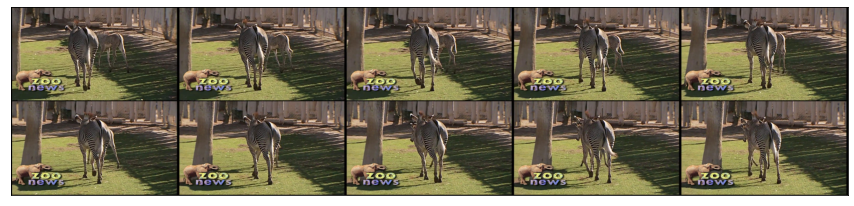

In [11]:
show_video_frames(frame_paths[:10])

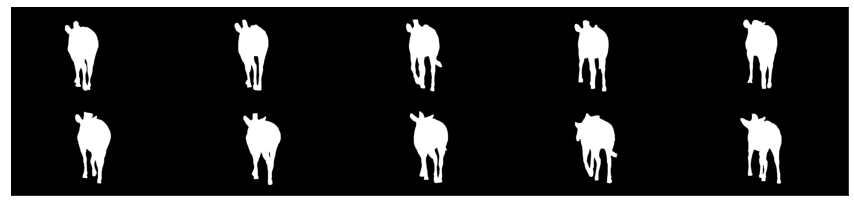

In [12]:
show_video_masks(masks_paths[:10], object_id=1)

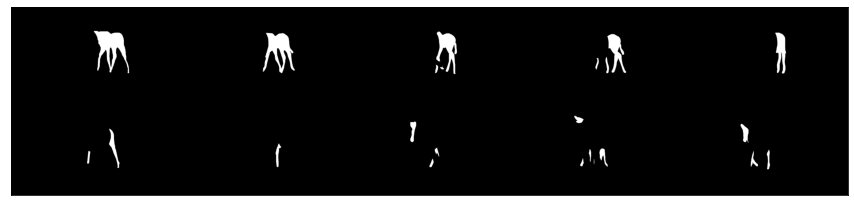

In [13]:
show_video_masks(masks_paths[:10], object_id=2)

### Visualize masks onto images

In [14]:
x = tv.io.read_image(frame_paths[0])
y = tv.io.read_image(masks_paths[0])

In [15]:
assert isinstance(x, torch.Tensor)
x.shape, x.dtype, x.min(), x.max(), y.shape, y.unique()

(torch.Size([3, 720, 1280]),
 torch.uint8,
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8),
 torch.Size([1, 720, 1280]),
 tensor([0, 1, 2], dtype=torch.uint8))

In [16]:
def overlay_mask_onto_image(image, mask, alpha=0.8, colors=None):

    assert isinstance(image, torch.Tensor)
    if image.dtype != torch.uint8:
        image = image.to(torch.uint8)
    
    assert image.shape[1:] == mask.shape[1:]
    assert image.shape[0] == 3
    assert mask.shape[0] == 1
    
    # get binarized masks for each object class
    object_ids = mask.unique()
    one_hot_masks = []
    for object_id in object_ids:
        if object_id > 0:
            one_hot_masks.append(mask == object_id)
    one_hot_masks = torch.cat(one_hot_masks, 0)

    overlaid_image = tv.utils.draw_segmentation_masks(image, one_hot_masks, alpha=alpha, colors=colors)
    return overlaid_image


def overlay_masks_onto_images(images, masks, colors=None, alpha=0.8):

    if colors is not None:
        assert len(colors) == len(masks[0].unique()) - 1

    overlaid_images = []
    for image, mask in zip(images, masks):
        overlaid_images.append(overlay_mask_onto_image(image, mask, alpha=alpha, colors=colors))
    
    return overlaid_images

In [17]:
overlaid = overlay_mask_onto_image(x, y, colors=["red", "limegreen"])

In [18]:
overlaid.shape

torch.Size([3, 720, 1280])

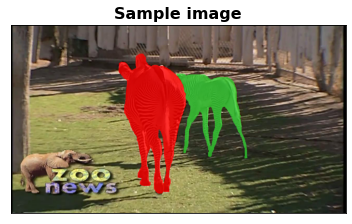

In [19]:
show_single_image(overlaid, normalized=False)

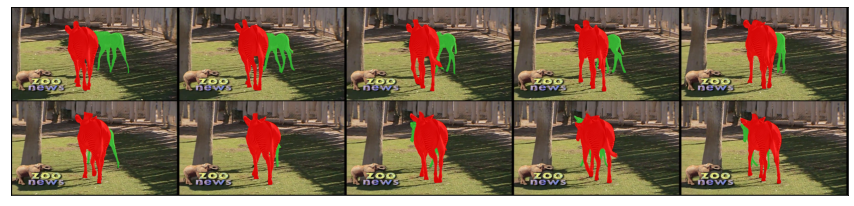

In [20]:
frames = [tv.io.read_image(x) for x in frame_paths[:10]]
masks = [tv.io.read_image(x) for x in masks_paths[:10]]

overlaid_images = overlay_masks_onto_images(frames, masks, colors=["red", "limegreen"])

grid = tv.utils.make_grid(overlaid_images, nrow=len(overlaid_images) // 2)
show_single_image(grid, normalized=False, figsize=(15, 5), title="")


### Filter "temporally challenging" expressions

In [21]:
train_expressions = load_json(get_expressions_path("train"))
valid_expressions = load_json(get_expressions_path("valid"))

total_expressions = {**train_expressions["videos"], **valid_expressions["videos"]}

len(train_expressions["videos"]), len(valid_expressions["videos"]), len(total_expressions)

(3471, 507, 3978)

In [37]:
keywords = [
    "before",
    "after",
    "during",
    "finish",
]

In [38]:
found = defaultdict(list)

for video_id in total_expressions:
    _dict = total_expressions[video_id]["expressions"]

    for key, value in _dict.items():
        if set(value["exp"].split(" ")).intersection(set(keywords)):
            found[video_id].append(value["exp"])


In [39]:
found

defaultdict(list,
            {'093c335ccc': ['a green frisbee disc flying in the air after being thrown by a player'],
             '0f51a78756': ['a white sheep directly in front of a black dog after turning around'],
             '16af445362': ['a dark grey plane with a letter a on it is landing on airstrip during the day'],
             '21df87ad76': ['a man on the right hand side of the last row just before the truck'],
             '27659fa7d6': ['a man in jeans catching a frisbee before throwing it to a man in red'],
             '28075f33c1': ['a crocodile at the edge of water with its mouth open before turning towards the water'],
             '2e03b8127a': ['a duck walking with its head down before lifting it up as it walks'],
             '2ea78f46e4': ['a small white rabbit sitting next to another before it jumps forward out of a box'],
             '3454303a08': ['a person is running before the tiger which is behind the glass wall'],
             '3b6c7988f6': ['a black co

In [41]:
len(found), sum([len(x) for k, x in found.items()])

(33, 36)

### Sample

In [30]:
video_id = "0390fabe580"

original_frame_paths = glob(join(DATASET_ROOT, f"valid/JPEGImages/{video_id}/0/*.png"))
annotated_frame_paths = glob(join(DATASET_ROOT, f"Annotations/{video_id}/0/*.png"))

In [31]:
len(annotated_frame_paths), len(original_frame_paths)

(18, 0)

In [9]:
frames = [tv.io.read_image(x) for x in frame_paths]

In [10]:
frames[0].shape

torch.Size([1, 720, 1280])

In [16]:
torch.stack(frames).shape

torch.Size([18, 1, 720, 1280])

In [25]:
grid = tv.utils.make_grid(torch.stack(frames), nrow=len(frames) // 2)

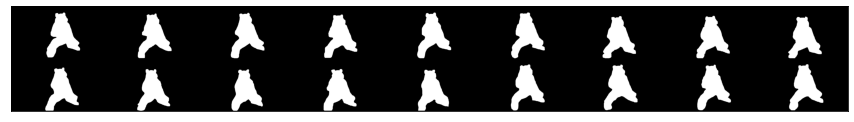

In [29]:
show_single_image(grid, normalized=False, figsize=(15, 5), title="")